In [1]:
import torch
import json
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
VOCAB_SIZE = 27
SOURCE = "names.txt"
SEP = "."
text = open(SOURCE, encoding="utf-8").read()
s_to_i = {chr(97 + i): i + 1 for i in range(VOCAB_SIZE - 1)}
s_to_i[SEP] = 0
i_to_s = {v: k for k, v in s_to_i.items()}

In [3]:
# basic tokenizer, encodes text into tokens(int) and
# decodes tokens(int) back to text

def encode(text):
    return [s_to_i[char] for char in text]

def decode(tokens):
    if isinstance(tokens, int):
        return i_to_s[tokens]
    return "".join([i_to_s[token] for token in tokens])

In [4]:
# stores probability of one character being followed by another
char_map = torch.ones((VOCAB_SIZE, VOCAB_SIZE))
# stores character frequency from the source text
freq = torch.zeros((VOCAB_SIZE, ))

with open(SOURCE, encoding="utf-8") as f:
    for name in f.read().splitlines():
        name = [SEP] + list(name) + [SEP]
        for char in name:
            freq[s_to_i[char]] += 1
        for c1, c2 in zip(name, name[1:]):
            i1, i2 = encode(c1), encode(c2)
            char_map[i1, i2] += 1

In [5]:
# get the probability of one character being followed by another
# c1 -> c2 = <prob>
# --------------------------------------------------------------

# P = char_map / char_map.sum(dim=1, keepdim=True)

# for i_row in range(P.shape[0]):
#     for i_col in range(P.shape[1]):
#         print("%s -> %s = %.4f" % (i_to_s[i_row], i_to_s[i_col], P[i_row][i_col] * 100))

In [5]:
Xs, Ys = [], []

with open(SOURCE, encoding="utf-8") as f:
    for name in f.read().splitlines():
        name = [SEP] + list(name) + [SEP]
        for c1, c2 in zip(name, name[1:]):
            Xs.append(s_to_i[c1])
            Ys.append(s_to_i[c2])

Xs, Ys = torch.tensor(Xs), torch.tensor(Ys)
# basic embedding, converts a token into a one hot vector
# of size VOCAB_SIZE(i.e 27)
x_emb = F.one_hot(Xs, num_classes=VOCAB_SIZE).float()
g = torch.Generator().manual_seed(1337)
W = torch.randn((VOCAB_SIZE, VOCAB_SIZE), generator=g, requires_grad=True)
# W.data = torch.tensor(json.load(open("W.json", encoding="utf-8")))
losses = []

In [6]:
# ALPHA is the hyperparameter that punishes
# the model for large values in the weights
ALPHA, LR = 0.01, 2
EPOCHS = 10000

for e in range(EPOCHS):
    if (e + 1) % (EPOCHS / 10) == 0:
        LR -= (LR / 10)
    # (num-of-samples, VOCAB_SIZE) = (num-of-samples, VOCAB_SIZE) @ (VOCAB_SIZE, VOCAB_SIZE)
    logits = x_emb @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(Xs.nelement()), Ys].log().mean() + ALPHA * (W ** 2).mean()
    print("%d: lr: %.2f, loss: %.4f" % (e + 1, LR, loss.item()))
    losses.append(loss.item())
    # reset any gradients set by the last iteration
    W.grad = None
    # compute gradients
    loss.backward()
    W.data -= LR * W.grad

1: lr: 2.00, loss: 2.4831
2: lr: 2.00, loss: 2.4831
3: lr: 2.00, loss: 2.4831
4: lr: 2.00, loss: 2.4831
5: lr: 2.00, loss: 2.4831
6: lr: 2.00, loss: 2.4831
7: lr: 2.00, loss: 2.4831
8: lr: 2.00, loss: 2.4831
9: lr: 2.00, loss: 2.4831
10: lr: 2.00, loss: 2.4831
11: lr: 2.00, loss: 2.4831
12: lr: 2.00, loss: 2.4831
13: lr: 2.00, loss: 2.4831
14: lr: 2.00, loss: 2.4831
15: lr: 2.00, loss: 2.4831
16: lr: 2.00, loss: 2.4831
17: lr: 2.00, loss: 2.4831
18: lr: 2.00, loss: 2.4831
19: lr: 2.00, loss: 2.4831
20: lr: 2.00, loss: 2.4831
21: lr: 2.00, loss: 2.4831
22: lr: 2.00, loss: 2.4831
23: lr: 2.00, loss: 2.4831
24: lr: 2.00, loss: 2.4831
25: lr: 2.00, loss: 2.4831
26: lr: 2.00, loss: 2.4831
27: lr: 2.00, loss: 2.4831
28: lr: 2.00, loss: 2.4831
29: lr: 2.00, loss: 2.4831
30: lr: 2.00, loss: 2.4831
31: lr: 2.00, loss: 2.4831
32: lr: 2.00, loss: 2.4831
33: lr: 2.00, loss: 2.4831
34: lr: 2.00, loss: 2.4831
35: lr: 2.00, loss: 2.4831
36: lr: 2.00, loss: 2.4831
37: lr: 2.00, loss: 2.4831
38: lr: 2.

In [ ]:
# probs[torch.arange(Xs.nelement(), Ys)]
# # predicted probabilities for the correct next tokens

# probs[torch.arange(Xs.nelement(), Ys)].log()
# # since probabilities are small values(<1), log gives large negative values for small positive values
# # why enlarge it: larger losses means large steps in overcoming the difference
# # between predictions and actual targets, the large values are only generated for
# # small input values(log(0) = inf, log(1) = 1), so if the model gets better and the
# # difference between prediction and target diminishes, the log will have less effect
# # in short: in amplifies the loss in initial steps so the model will take big steps in
# # the beginning

# probs[torch.arange(Xs.nelement(), Ys)].log().mean()
# # we take the mean of all those logged probabilities
# # in other words, loss becomes the mean of all mistakes

# what's the negative mark doing
# # since the logged probability values become large negative values
# # the negative mark converts it back to positive

# ALPHA * (W ** 2) => it's called regularization factor, regularizes(tames) the weights
# # increases the loss if the weight values are too big(>1)
# # why? larger values have been shown to destabilize training
# # intuition: the regularization factor only has an effect if a log of weight
# # values are big(>1), since (>1) * (>1) = >>1, if the weights are small(<1)
# # the regularization factor becomes a non-factor, since (<1) * (<1) = <<1
# # in short: it makes the model work to both get accurate results and keep the model
# # as small as possible, ALPHA makes sure that this factor doesn;t become too dominant compared
# # to the actual loss computed on the probabilities

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


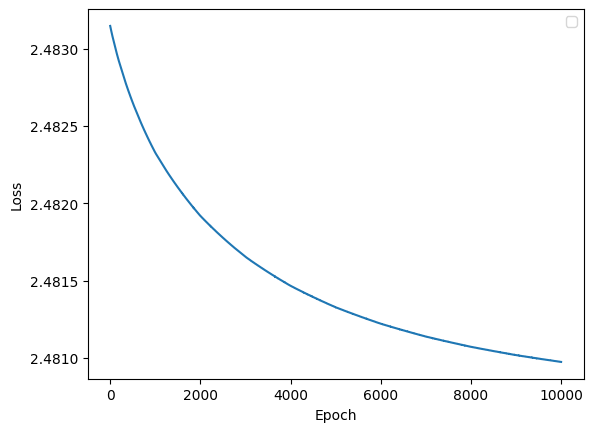

In [7]:
plt.plot(range(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
# sampling
NO_SAMPLES = 10

for _ in range(NO_SAMPLES):
    start_token, out_tokens = 0, []
    while True:
        x_emb = F.one_hot(torch.tensor([start_token]), num_classes=VOCAB_SIZE).float()
        logits = x_emb @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
        next_token = torch.multinomial(probs, num_samples=1).item()
        if next_token == s_to_i[SEP]:
            break
        start_token = next_token
        out_tokens.append(next_token)
    print(decode(out_tokens))

ana
ielavipamdaly
ja
el
rtzitokiariaee
fa
yaynchar
sh
ymabef
jash
